In [27]:
# More screen realestate
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#header-container      { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

In [3]:
import json

from pyspark.sql import SparkSession

from pyspark.sql.types import *
import pyspark.sql.types as spark_types

def spark_schema_from_json(j):
    return StructType([
        StructField(
            f["name"],
            spark_types._parse_datatype_string(f.get("type", "string")),
            f.get("nullable", True),
            f.get("metadata", None)
        )
        for f in j
    ])

spark = SparkSession.builder.master("local").appName("GH Users").getOrCreate()

In [23]:
with open("ghtorrent-schema.json") as f:
    db_schema = json.load(f)

df = spark.read.csv(
#     path="/mnt/Data/GHTorrent/users_head.csv",
    path="/mnt/Data/GHTorrent/users.csv",
    schema=spark_schema_from_json(db_schema["users.csv"]),
    nullValue="\\N",
)

# df.count()

# Users who have perfectly mapped location data
df2 = df.filter(df.country_code.isNotNull())

# df2.count()

# Users who have data in location field but which couldn't be mapped to a
# country etc.
# df3 = df.filter(df.country_code.isNull() & df.location.isNotNull())

# df3.count()

# Such users from India?
# df4 = df3.filter(df.location.rlike("\\bIndia\\b"))

### Companies with most GitHub users 

In [71]:
# People who have a company
df_company = df.filter(df.company.isNotNull() & ~ (df.company.isin(["NA", "N/A", "None", "none", "-", "Personal", "Student", "student", "self", "Self", "Home", "Freelance", "Freelancer"])) & ~ (df.company.contains("CLICK ")))

# People who claim to be from India
df5 = df_company.filter(df.location.rlike("\\bIndia\\b"))

# Count & Sort
df6 = df_company.groupby("company").count().sort("count", ascending=False)

# Which IIT is at the top?
df6.filter(df.company.startswithith("IIT")).show(20, False)

In [72]:
# Companies with most GitHub users

df6 = df_company.groupby("company").count().sort("count", ascending=False)

df6.show(20, False)

+--------------------------+-----+
|company                   |count|
+--------------------------+-----+
|Microsoft                 |7443 |
|IBM                       |2804 |
|Google                    |2725 |
|Red Hat                   |1669 |
|Japan                     |1116 |
|Intel                     |1027 |
|ThoughtWorks              |937  |
|Facebook                  |925  |
|Carnegie Mellon University|892  |
|Esri                      |888  |
|Tencent                   |818  |
|Stanford University       |764  |
|University of Washington  |709  |
|Oracle                    |672  |
|Accenture                 |656  |
|Microsoft Corporation     |628  |
|UC Berkeley               |607  |
|Tsinghua University       |561  |
|Columbia University       |557  |
|Baidu                     |552  |
+--------------------------+-----+
only showing top 20 rows



In [81]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

### Users Year Country Count

In [25]:
df4 = (
    df2
    .select(F.year(df2.created_at).name("year"), "country_code")
    .groupby("year", "country_code")
    .count()
    .sort("count", ascending=False)
)

# df4.show()

In [28]:
# df4.count()
df4.coalesce(1).write.json("user-year-country-count.json")

In [34]:
import pandas as pd
odf = pd.read_json(open("../outputs/user-year-country-count.json"), lines=True)

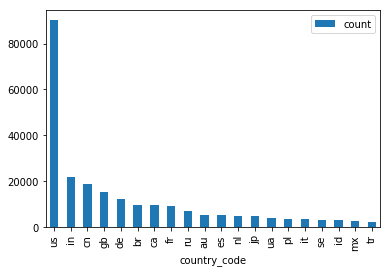

In [68]:
plt.figure()

odf2 = odf.loc[odf.year == 2014]
odf2.sort_values("count")
odf2.head(20).plot.bar(x="country_code", y="count")
